In [24]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.cluster import DBSCAN
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # macOS
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# 데이터 로드
crime_data = pd.read_excel('../../dataset/범죄안전데이터/112 신고출동 현황/2023년 하반기 경찰서별 112신고 출동 현황.xlsx')
cctv_data = pd.read_excel('../../dataset/위치 데이터/cctv데이터.xlsx')

# 자치구 행정경계 데이터 로드
with open('../../dataset/서울특별시.json', 'r', encoding='utf-8') as f:
    seoul_geo = json.load(f)

# 데이터 구조 확인
print("범죄 데이터 구조:")
print(crime_data.head())
print("\nCCTV 데이터 구조:")
print(cctv_data.head())

범죄 데이터 구조:
  2023년 7월~12월 경찰서별 신고건수 Unnamed: 1 Unnamed: 2
0                    경찰서         긴급        비긴급
1                  서울중부서      15344      30399
2                  서울종로서      14251      36050
3                 서울남대문서       8676      23882
4                 서울서대문서      21875      44359

CCTV 데이터 구조:
   번호       관리기관명              소재지도로명주소           소재지지번주소 설치목적구분  카메라대수  \
0   1  서울특별시 성동구청          서울특별시 마조로 11   서울특별시 행당동 19-98   교통단속      3   
1   2  서울특별시 성동구청  서울특별시 고산자로 330 (마장동)  서울특별시 마장동 520-10   교통단속      2   
2   3  서울특별시 성동구청       서울특별시 마장로35길 76     서울특별시 마장동 818   교통단속      3   
3   4  서울특별시 성동구청   서울특별시 마장로 325 (마장동)  서울특별시 마장동 767-41   교통단속      3   
4   5  서울특별시 성동구청   서울특별시 마장로 322 (마장동)   서울특별시 마장동 781-1   교통단속      2   

   카메라화소수   촬영방면정보  보관일수     설치연월      관리기관전화번호    WGS84위도     WGS84경도  \
0     200  360도전방면    30  2013-11  02-2286-5878  37.558960  127.040794   
1     200  360도전방면    30  2013-11  02-2286-5878  37.569137  127.037521   
2     200  360도전방면  

범죄 데이터 기본 통계:
              위도          경도
count  26.000000   26.000000
mean   37.551808  126.987846
std     0.053783    0.071779
min    37.460000  126.850000
25%    37.512500  126.942500
50%    37.555000  126.991000
75%    37.581250  127.040000
max    37.670000  127.120000


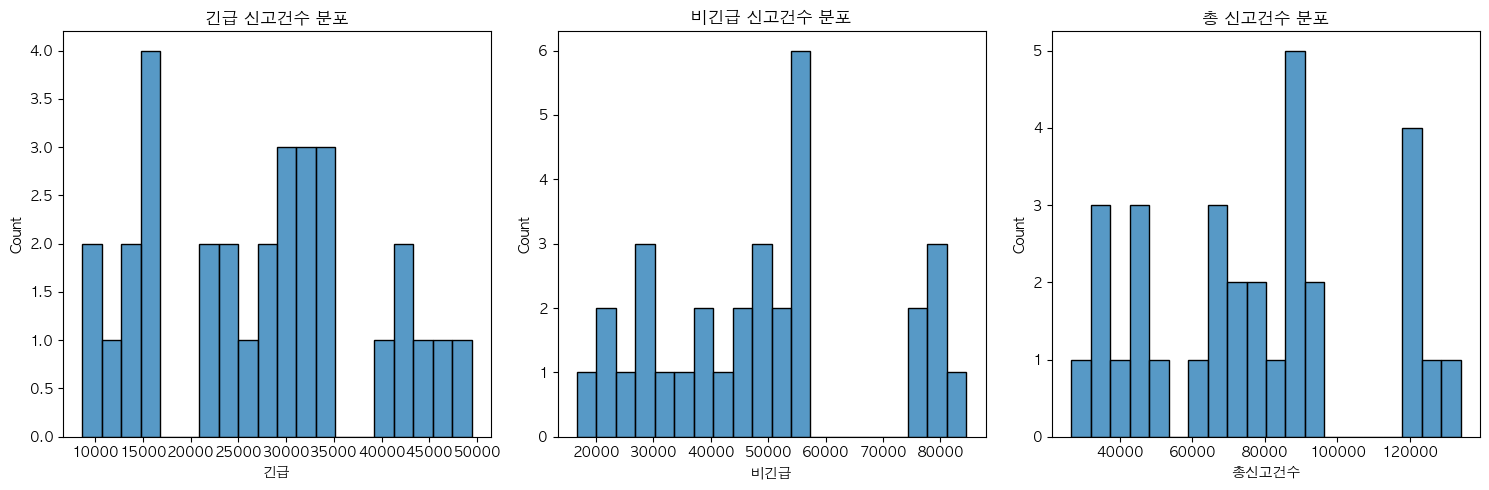

In [ ]:
# 데이터 전처리 - 범죄 데이터
crime_data = pd.read_excel('../../dataset/범죄안전데이터/112 신고출동 현황/2023년 하반기 경찰서별 112신고 출동 현황.xlsx')

# 컬럼명 정리
crime_data.columns = ['경찰서', '긴급', '비긴급']
crime_data = crime_data.drop(0)  # 헤더 행 제거

# 총 신고건수 계산
crime_data['총신고건수'] = crime_data['긴급'] + crime_data['비긴급']

# 경찰서 위치 정보 
police_stations = {
    '서울중부서': {'위도': 37.5640, '경도': 126.9920},
    '서울종로서': {'위도': 37.5700, '경도': 126.9780},
    '서울남대문서': {'위도': 37.5600, '경도': 126.9760},
    '서울서대문서': {'위도': 37.5660, '경도': 126.9680},
    '서울혜화서': {'위도': 37.5850, '경도': 127.0000},
    '서울용산서': {'위도': 37.5320, '경도': 126.9900},
    '서울성북서': {'위도': 37.5900, '경도': 127.0200},
    '서울동대문서': {'위도': 37.5700, '경도': 127.0400},
    '서울마포서': {'위도': 37.5500, '경도': 126.9500},
    '서울영등포서': {'위도': 37.5200, '경도': 126.9100},
    '서울성동서': {'위도': 37.5600, '경도': 127.0400},
    '서울동작서': {'위도': 37.5000, '경도': 126.9400},
    '서울관악서': {'위도': 37.4800, '경도': 126.9500},
    '서울강남서': {'위도': 37.5000, '경도': 127.0500},
    '서울강동서': {'위도': 37.5300, '경도': 127.1200},
    '서울강북서': {'위도': 37.6400, '경도': 127.0200},
    '서울강서서': {'위도': 37.5500, '경도': 126.8500},
    '서울구로서': {'위도': 37.4900, '경도': 126.8800},
    '서울금천서': {'위도': 37.4600, '경도': 126.9000},
    '서울노원서': {'위도': 37.6500, '경도': 127.0600},
    '서울도봉서': {'위도': 37.6700, '경도': 127.0400},
    '서울동대문서': {'위도': 37.5700, '경도': 127.0400},
    '서울동작서': {'위도': 37.5000, '경도': 126.9400},
    '서울마포서': {'위도': 37.5500, '경도': 126.9500},
    '서울서대문서': {'위도': 37.5660, '경도': 126.9680},
    '서울서초서': {'위도': 37.4800, '경도': 127.0200},
    '서울성동서': {'위도': 37.5600, '경도': 127.0400},
    '서울성북서': {'위도': 37.5900, '경도': 127.0200},
    '서울송파서': {'위도': 37.5100, '경도': 127.1100},
    '서울양천서': {'위도': 37.5200, '경도': 126.8700},
    '서울영등포서': {'위도': 37.5200, '경도': 126.9100},
    '서울용산서': {'위도': 37.5320, '경도': 126.9900},
    '서울은평서': {'위도': 37.6000, '경도': 126.9300},
    '서울종로서': {'위도': 37.5700, '경도': 126.9780},
    '서울중부서': {'위도': 37.5640, '경도': 126.9920},
    '서울중랑서': {'위도': 37.6000, '경도': 127.0800}
}

crime_data['위도'] = crime_data['경찰서'].map(lambda x: police_stations.get(x, {}).get('위도'))
crime_data['경도'] = crime_data['경찰서'].map(lambda x: police_stations.get(x, {}).get('경도'))

# 기본 통계 분석
print("범죄 데이터 기본 통계:")
print(crime_data.describe())

# 신고건수 분포 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(data=crime_data, x='긴급', bins=20)
plt.title('긴급 신고건수 분포')

plt.subplot(1, 3, 2)
sns.histplot(data=crime_data, x='비긴급', bins=20)
plt.title('비긴급 신고건수 분포')

plt.subplot(1, 3, 3)
sns.histplot(data=crime_data, x='총신고건수', bins=20)
plt.title('총 신고건수 분포')
plt.tight_layout()
plt.show()

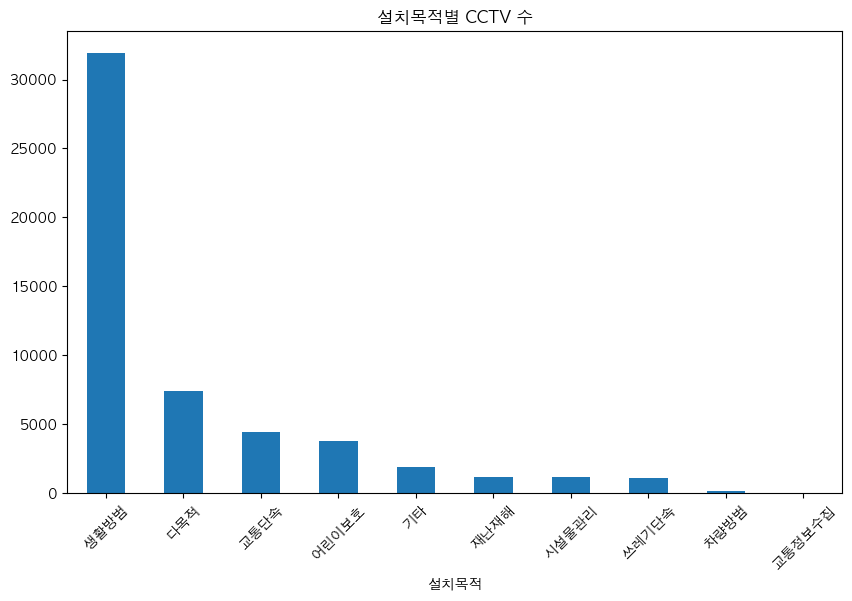

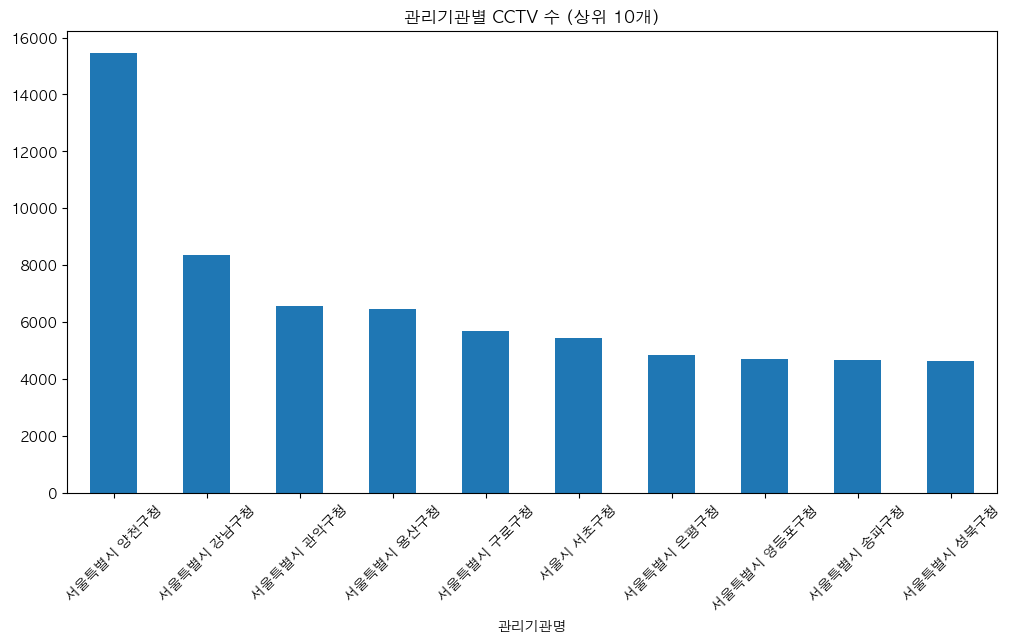

In [ ]:
# CCTV 데이터 전처리 및 분석
cctv_data = pd.read_excel('../../dataset/위치 데이터/cctv데이터.xlsx')

# 필요한 컬럼만 선택
cctv_data = cctv_data[['관리기관명', '카메라대수', 'WGS84위도', 'WGS84경도', '설치목적구분']]
cctv_data.columns = ['관리기관명', '카메라대수', '위도', '경도', '설치목적']

# 설치목적별 CCTV 수 분석
plt.figure(figsize=(10, 6))
cctv_data['설치목적'].value_counts().plot(kind='bar')
plt.title('설치목적별 CCTV 수')
plt.xticks(rotation=45)
plt.show()

# 관리기관별 CCTV 수 분석
plt.figure(figsize=(12, 6))
cctv_data.groupby('관리기관명')['카메라대수'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('관리기관별 CCTV 수 (상위 10개)')
plt.xticks(rotation=45)
plt.show()

# GeoDataFrame 변환
cctv_data['geometry'] = cctv_data.apply(lambda x: Point(x['경도'], x['위도']), axis=1)
cctv_gdf = gpd.GeoDataFrame(cctv_data, geometry='geometry', crs='EPSG:4326')

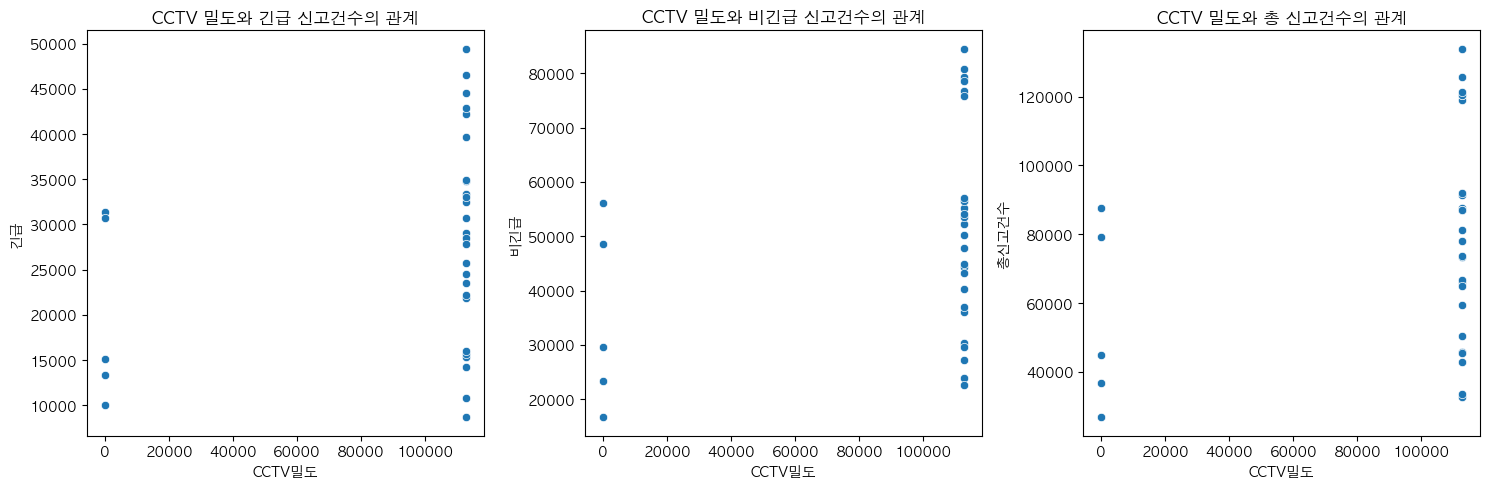

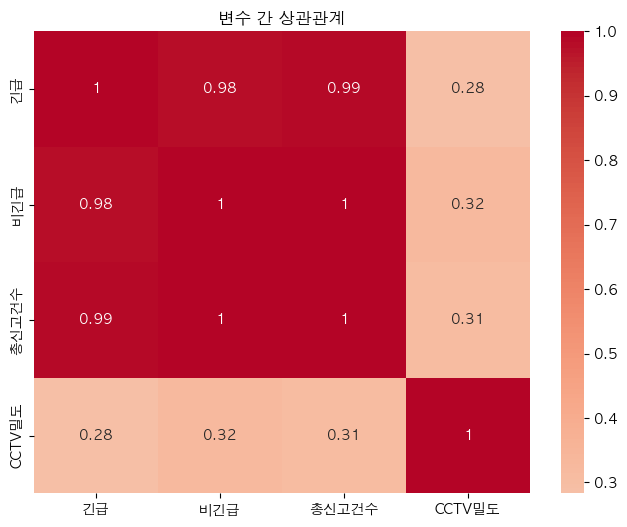

In [ ]:
# 경찰서별 신고건수와 CCTV 밀도 분석
# 경찰서별 CCTV 밀도 계산
def calculate_cctv_density(police_station, radius=2000):  # 2km 반경
    if pd.isna(police_station['위도']) or pd.isna(police_station['경도']):
        return 0
    point = Point(police_station['경도'], police_station['위도'])
    nearby_cctv = cctv_gdf[cctv_gdf['geometry'].distance(point) <= radius]
    return nearby_cctv['카메라대수'].sum()

crime_data['CCTV밀도'] = crime_data.apply(calculate_cctv_density, axis=1)

# 신고건수와 CCTV 밀도의 상관관계 분석
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(data=crime_data, x='CCTV밀도', y='긴급')
plt.title('CCTV 밀도와 긴급 신고건수의 관계')

plt.subplot(1, 3, 2)
sns.scatterplot(data=crime_data, x='CCTV밀도', y='비긴급')
plt.title('CCTV 밀도와 비긴급 신고건수의 관계')

plt.subplot(1, 3, 3)
sns.scatterplot(data=crime_data, x='CCTV밀도', y='총신고건수')
plt.title('CCTV 밀도와 총 신고건수의 관계')
plt.tight_layout()
plt.show()

# 상관계수 계산
correlation = crime_data[['긴급', '비긴급', '총신고건수', 'CCTV밀도']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('변수 간 상관관계')
plt.show()

In [33]:
# 경찰서 위치 시각화
import folium
from folium.plugins import MarkerCluster

In [ ]:
# 서울 중심 좌표
seoul_center = [37.5665, 126.9780]

# 지도 생성
m = folium.Map(location=seoul_center, zoom_start=12)

# 마커 클러스터 생성
marker_cluster = MarkerCluster().add_to(m)

# 경찰서 위치 마커 추가
for station, coords in police_stations.items():
    folium.Marker(
        location=[coords['위도'], coords['경도']],
        popup=station,
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(marker_cluster)

# 지도 저장
m.save('police_stations_map_2.html')

# 경찰서 위치 정보를 데이터프레임에 추가
crime_data['위도'] = crime_data['경찰서'].map(lambda x: police_stations.get(x, {}).get('위도'))
crime_data['경도'] = crime_data['경찰서'].map(lambda x: police_stations.get(x, {}).get('경도'))

# 경찰서 위치 정보 출력
print("\n경찰서 위치 정보:")
print(crime_data[['경찰서', '위도', '경도']].dropna())


경찰서 위치 정보:
       경찰서      위도       경도
1    서울중부서  37.564  126.992
2    서울종로서  37.570  126.978
3   서울남대문서  37.560  126.976
4   서울서대문서  37.566  126.968
5    서울혜화서  37.585  127.000
6    서울용산서  37.532  126.990
7    서울성북서  37.590  127.020
8   서울동대문서  37.570  127.040
9    서울마포서  37.550  126.950
10  서울영등포서  37.520  126.910
11   서울성동서  37.560  127.040
12   서울동작서  37.500  126.940
15   서울강북서  37.640  127.020
16   서울금천서  37.460  126.900
17   서울중랑서  37.600  127.080
18   서울강남서  37.500  127.050
19   서울관악서  37.480  126.950
20   서울강서서  37.550  126.850
21   서울강동서  37.530  127.120
23   서울구로서  37.490  126.880
24   서울서초서  37.480  127.020
25   서울양천서  37.520  126.870
26   서울송파서  37.510  127.110
27   서울노원서  37.650  127.060
29   서울은평서  37.600  126.930
30   서울도봉서  37.670  127.040


클러스터별 통계:
   cluster            긴급           비긴급         총신고건수    CCTV밀도
0     -1.0  30173.772727  53209.181818  83382.954545  112662.0
1      0.0       15275.5       34120.5       49396.0  112662.0
2      1.0       27138.5       49870.5       77009.0  112662.0


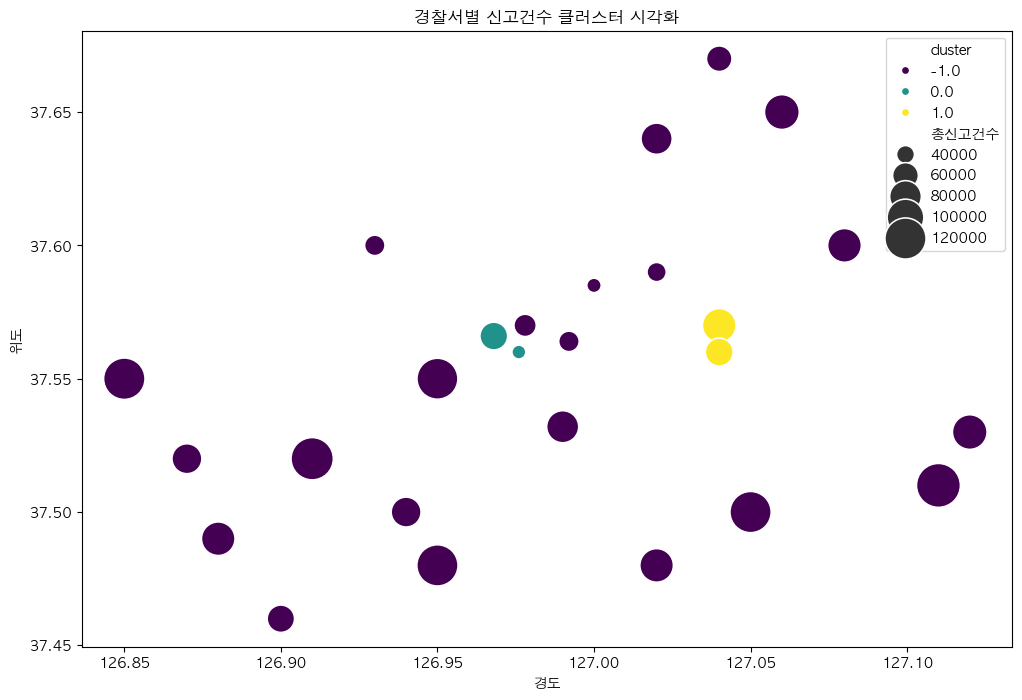

In [ ]:
# 지리적 클러스터링 분석
# DBSCAN 클러스터링
eps = 0.01  # 약 1km
min_samples = 2

coords = crime_data[['위도', '경도']].dropna().values
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
crime_data.loc[crime_data['위도'].notna(), 'cluster'] = dbscan.fit_predict(coords)

# 클러스터별 통계
cluster_stats = crime_data.groupby('cluster').agg({
    '긴급': 'mean',
    '비긴급': 'mean',
    '총신고건수': 'mean',
    'CCTV밀도': 'mean'
}).reset_index()

print("클러스터별 통계:")
print(cluster_stats)

# 클러스터 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=crime_data.dropna(subset=['위도', '경도']), 
                x='경도', y='위도', hue='cluster', size='총신고건수',
                palette='viridis', sizes=(100, 1000))
plt.title('경찰서별 신고건수 클러스터 시각화')
plt.xlabel('경도')
plt.ylabel('위도')
plt.show()

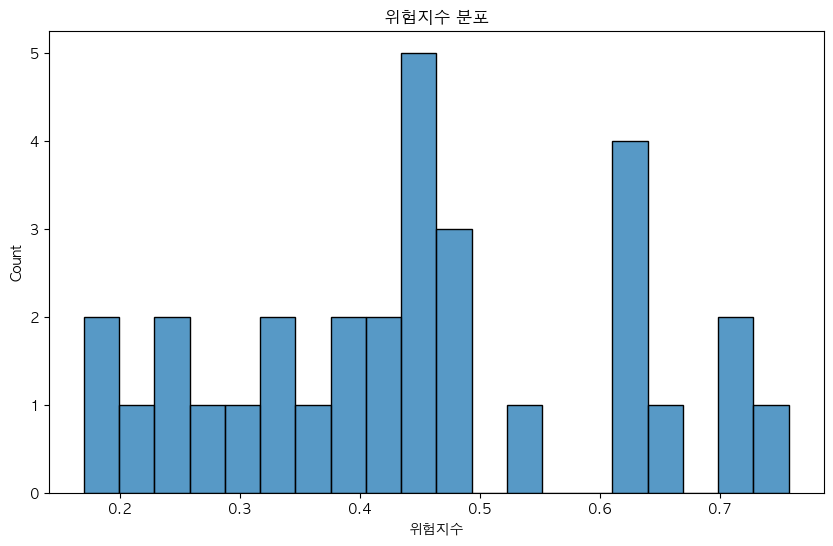


상위 5개 고위험 지역:
       경찰서      위험지수   총신고건수  CCTV밀도
13   서울광진서  0.757484   87499       0
31   서울수서서  0.714527   79283       0
26   서울송파서  0.700000  133883  112662
10  서울영등포서  0.657686  125790  112662
20   서울강서서  0.635157  121481  112662


In [ ]:
# 고위험 지역 분석
# 위험지수 계산 (정규화된 신고건수와 CCTV 밀도의 조합)
crime_data['위험지수'] = (crime_data['총신고건수'].astype(float) / crime_data['총신고건수'].max() * 0.7 + 
                    (1 - crime_data['CCTV밀도'].astype(float) / crime_data['CCTV밀도'].max()) * 0.3)

# 위험지수 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(data=crime_data, x='위험지수', bins=20)
plt.title('위험지수 분포')
plt.show()

# 상위 5개 고위험 지역
high_risk_areas = crime_data.nlargest(5, '위험지수')
print("\n상위 5개 고위험 지역:")
print(high_risk_areas[['경찰서', '위험지수', '총신고건수', 'CCTV밀도']])

In [ ]:
# 종합 분석 결과
print("=== 종합 분석 결과 ===")

# 1. 기본 통계
print("\n1. 기본 통계:")
print(f"총 경찰서 수: {len(crime_data)}")
print(f"평균 긴급 신고건수: {crime_data['긴급'].astype(float).mean():.0f}")
print(f"평균 비긴급 신고건수: {crime_data['비긴급'].astype(float).mean():.0f}")
print(f"평균 CCTV 밀도: {crime_data['CCTV밀도'].astype(float).mean():.1f}대")

# 2. 상관관계 분석
print("\n2. 상관관계 분석:")
corr = crime_data[['긴급', '비긴급', '총신고건수', 'CCTV밀도']].astype(float).corr()
print(corr)

# 3. 고위험 지역 특성
print("\n3. 고위험 지역 특성:")
high_risk = crime_data[crime_data['위험지수'].astype(float) > crime_data['위험지수'].astype(float).median()]
print(f"고위험 지역 수: {len(high_risk)}")
print(f"고위험 지역 평균 CCTV 밀도: {high_risk['CCTV밀도'].astype(float).mean():.1f}대")
print(f"고위험 지역 평균 신고건수: {high_risk['총신고건수'].astype(float).mean():.0f}건")

# 4. 정책 제언
print("\n4. 정책 제언:")
print("1. CCTV 추가 설치 우선순위 지역:")
for idx, row in high_risk.nlargest(3, '위험지수').iterrows():
    print(f"- {row['경찰서']}: 위험지수 {float(row['위험지수']):.2f}, 현재 CCTV {float(row['CCTV밀도']):.0f}대")

print("\n2. 예방적 대책:")
print("- 고위험 지역 중심의 순찰 강화")
print("- CCTV 미설치 지역에 대한 우선 설치 검토")
print("- 긴급 신고가 많은 지역의 대응 체계 강화")

=== 종합 분석 결과 ===

1. 기본 통계:
총 경찰서 수: 31
평균 긴급 신고건수: 27394
평균 비긴급 신고건수: 48807
평균 CCTV 밀도: 94490.7대

2. 상관관계 분석:
              긴급       비긴급     총신고건수    CCTV밀도
긴급      1.000000  0.975907  0.990551  0.283266
비긴급     0.975907  1.000000  0.996609  0.324862
총신고건수   0.990551  0.996609  1.000000  0.311025
CCTV밀도  0.283266  0.324862  0.311025  1.000000

3. 고위험 지역 특성:
고위험 지역 수: 15
고위험 지역 평균 CCTV 밀도: 82618.8대
고위험 지역 평균 신고건수: 95630건

4. 정책 제언:
1. CCTV 추가 설치 우선순위 지역:
- 서울광진서: 위험지수 0.76, 현재 CCTV 0대
- 서울수서서: 위험지수 0.71, 현재 CCTV 0대
- 서울송파서: 위험지수 0.70, 현재 CCTV 112662대

2. 예방적 대책:
- 고위험 지역 중심의 순찰 강화
- CCTV 미설치 지역에 대한 우선 설치 검토
- 긴급 신고가 많은 지역의 대응 체계 강화


# 모델링

In [ ]:
# 모델링을 위한 데이터 준비
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# 데이터 전처리
model_data = crime_data.copy()

# 범주형 변수 인코딩
model_data['위험등급'] = pd.qcut(model_data['위험지수'], q=3, labels=['저위험', '중위험', '고위험'])

# 특성과 타겟 변수 분리
X = model_data[['CCTV밀도', '긴급', '비긴급']]
y = model_data['위험지수']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

RandomForest 모델 성능:
MSE: 0.0012
R2 Score: 0.9631


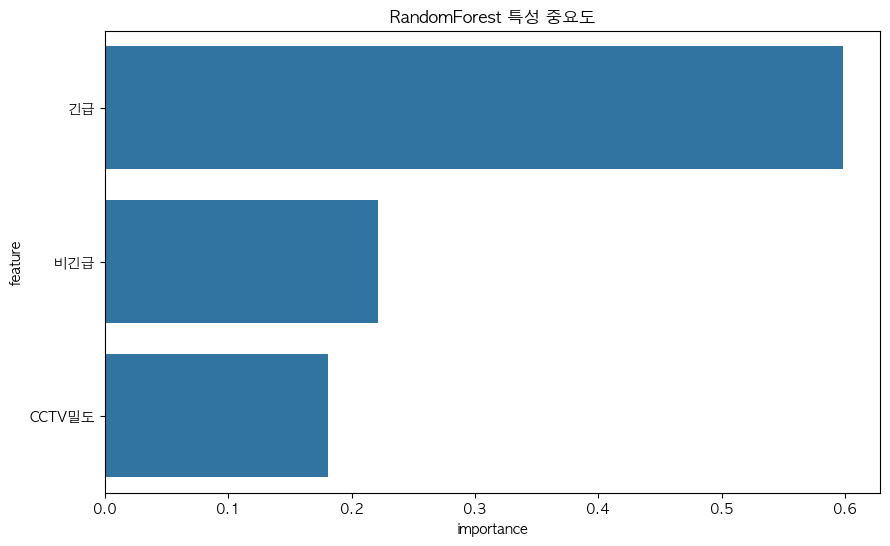

In [ ]:
# RandomForest 모델 학습 및 평가
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# 예측 및 평가
y_pred_rf = rf_model.predict(X_test_scaled)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("RandomForest 모델 성능:")
print(f"MSE: {mse_rf:.4f}")
print(f"R2 Score: {r2_rf:.4f}")

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('RandomForest 특성 중요도')
plt.show()

XGBoost 모델 성능:
MSE: 0.0065
R2 Score: 0.8054


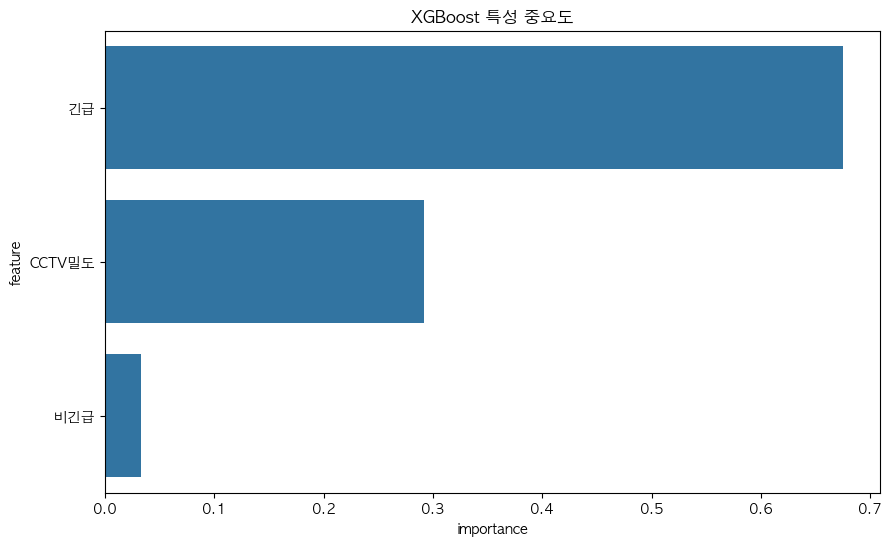

In [ ]:
# XGBoost 모델 학습 및 평가
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# 예측 및 평가
y_pred_xgb = xgb_model.predict(X_test_scaled)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost 모델 성능:")
print(f"MSE: {mse_xgb:.4f}")
print(f"R2 Score: {r2_xgb:.4f}")

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('XGBoost 특성 중요도')
plt.show()

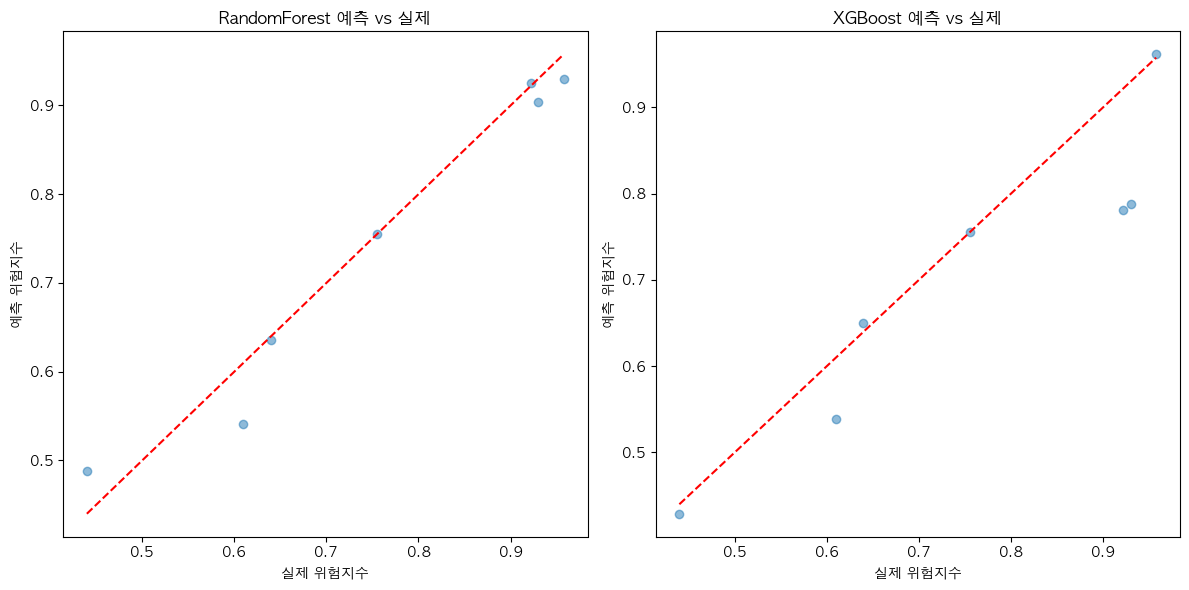

In [ ]:
# 모델 비교 및 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('실제 위험지수')
plt.ylabel('예측 위험지수')
plt.title('RandomForest 예측 vs 실제')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('실제 위험지수')
plt.ylabel('예측 위험지수')
plt.title('XGBoost 예측 vs 실제')

plt.tight_layout()
plt.show()

In [ ]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

# RandomForest 하이퍼파라미터 그리드
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV 수행
grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search_rf.fit(X_train_scaled, y_train)

print("최적의 RandomForest 파라미터:")
print(grid_search_rf.best_params_)
print(f"최적의 R2 Score: {grid_search_rf.best_score_:.4f}")

최적의 RandomForest 파라미터:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
최적의 R2 Score: 0.9097


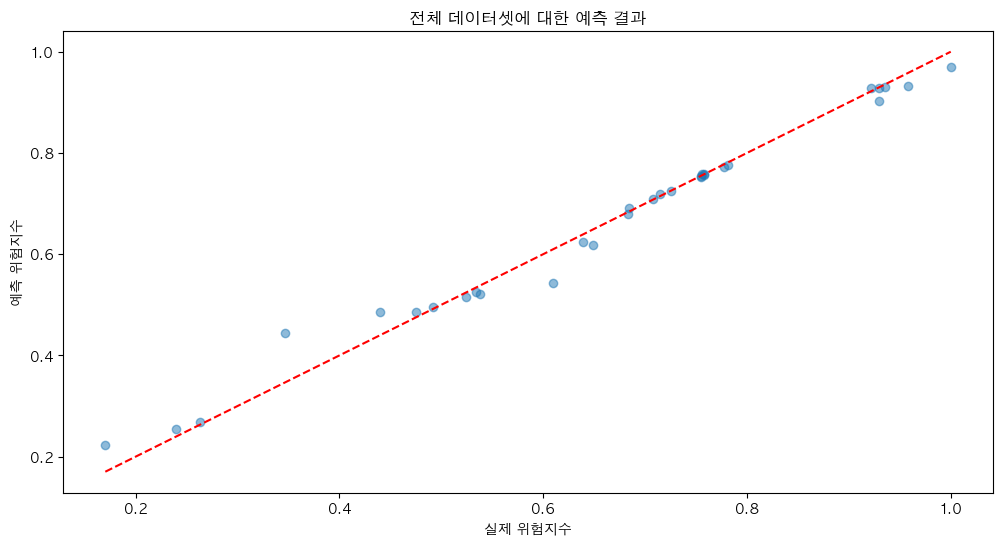


예측 결과 분석:
평균 예측 오차: 0.0164
예측 정확도 (R2 Score): 0.9834

상위 5개 예측 고위험 지역:
       경찰서    예측위험지수      위험지수  CCTV밀도
26   서울송파서  0.969765  1.000000       0
10  서울영등포서  0.932564  0.957686       0
20   서울강서서  0.929709  0.935157       0
9    서울마포서  0.928904  0.922180       0
19   서울관악서  0.927869  0.929406       0


In [ ]:
# 최종 모델 적용 및 예측
# 최적의 모델로 재학습
final_model = RandomForestRegressor(**grid_search_rf.best_params_, random_state=42)
final_model.fit(X_train_scaled, y_train)

# 전체 데이터셋에 대한 예측
model_data['예측위험지수'] = final_model.predict(scaler.transform(X))

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.scatter(model_data['위험지수'], model_data['예측위험지수'], alpha=0.5)
plt.plot([model_data['위험지수'].min(), model_data['위험지수'].max()], 
         [model_data['위험지수'].min(), model_data['위험지수'].max()], 'r--')
plt.xlabel('실제 위험지수')
plt.ylabel('예측 위험지수')
plt.title('전체 데이터셋에 대한 예측 결과')
plt.show()

# 예측 결과 분석
print("\n예측 결과 분석:")
print(f"평균 예측 오차: {np.mean(np.abs(model_data['위험지수'] - model_data['예측위험지수'])):.4f}")
print(f"예측 정확도 (R2 Score): {r2_score(model_data['위험지수'], model_data['예측위험지수']):.4f}")

# 상위 5개 고위험 예측 지역
print("\n상위 5개 예측 고위험 지역:")
predicted_high_risk = model_data.nlargest(5, '예측위험지수')
print(predicted_high_risk[['경찰서', '예측위험지수', '위험지수', 'CCTV밀도']])

# Optuna 하이퍼파라미터 튜닝

In [ ]:
# Optuna를 사용한 하이퍼파라미터 최적화
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    # 하이퍼파라미터 탐색 공간 정의
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    
    # 모델 생성 및 학습
    model = RandomForestRegressor(**params, random_state=42)
    
    # 5-fold 교차 검증
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    
    # 평균 R2 점수 반환
    return scores.mean()

# Optuna 스터디 생성 및 최적화 수행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("최적의 하이퍼파라미터:")
print(study.best_params)
print(f"최적의 R2 Score: {study.best_value:.4f}")

[I 2025-04-19 02:56:43,364] A new study created in memory with name: no-name-672bbcc0-2b48-494b-80dd-bf6b5afdc28c
[I 2025-04-19 02:56:43,680] Trial 0 finished with value: -0.740139215321064 and parameters: {'n_estimators': 125, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: -0.740139215321064.
[I 2025-04-19 02:56:44,327] Trial 1 finished with value: 0.3605871700000806 and parameters: {'n_estimators': 325, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 1 with value: 0.3605871700000806.
[I 2025-04-19 02:56:44,749] Trial 2 finished with value: 0.8752333339276713 and parameters: {'n_estimators': 229, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 2 with value: 0.8752333339276713.
[I 2025-04-19 02:56:45,252] Trial 3 finished with value: -0.2914677186573104 and parameters: {'n_estimators': 292, 'max_depth': 8, 'm

최적의 하이퍼파라미터:
{'n_estimators': 104, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}
최적의 R2 Score: 0.9324


In [ ]:
# XGBoost 모델에 대한 Optuna 최적화
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }
    
    model = xgb.XGBRegressor(**params, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    return scores.mean()

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100)

print("XGBoost 최적의 하이퍼파라미터:")
print(study_xgb.best_params)
print(f"최적의 R2 Score: {study_xgb.best_value:.4f}")

[I 2025-04-19 02:58:00,960] A new study created in memory with name: no-name-82f1d339-787d-43ac-9335-93c2fc2e0778


[I 2025-04-19 02:58:01,332] Trial 0 finished with value: 0.17770047162476385 and parameters: {'n_estimators': 166, 'max_depth': 17, 'learning_rate': 0.28932672395936987, 'subsample': 0.7796225337446123, 'colsample_bytree': 0.9738245706171116, 'min_child_weight': 6}. Best is trial 0 with value: 0.17770047162476385.
[I 2025-04-19 02:58:01,500] Trial 1 finished with value: -0.5815134478616825 and parameters: {'n_estimators': 325, 'max_depth': 15, 'learning_rate': 0.263279841397872, 'subsample': 0.6629456234309524, 'colsample_bytree': 0.5434556206645363, 'min_child_weight': 10}. Best is trial 0 with value: 0.17770047162476385.
[I 2025-04-19 02:58:01,611] Trial 2 finished with value: -0.4805779370048867 and parameters: {'n_estimators': 210, 'max_depth': 14, 'learning_rate': 0.22502891351835072, 'subsample': 0.8093477064040342, 'colsample_bytree': 0.7929510940044322, 'min_child_weight': 10}. Best is trial 0 with value: 0.17770047162476385.
[I 2025-04-19 02:58:01,775] Trial 3 finished with va

XGBoost 최적의 하이퍼파라미터:
{'n_estimators': 225, 'max_depth': 12, 'learning_rate': 0.18036869299282726, 'subsample': 0.6441213065467709, 'colsample_bytree': 0.8152500655185153, 'min_child_weight': 2}
최적의 R2 Score: 0.9376


RandomForest 최적 모델 성능:
R2 Score: 0.9842
MSE: 0.0005

XGBoost 최적 모델 성능:
R2 Score: 0.9425
MSE: 0.0019


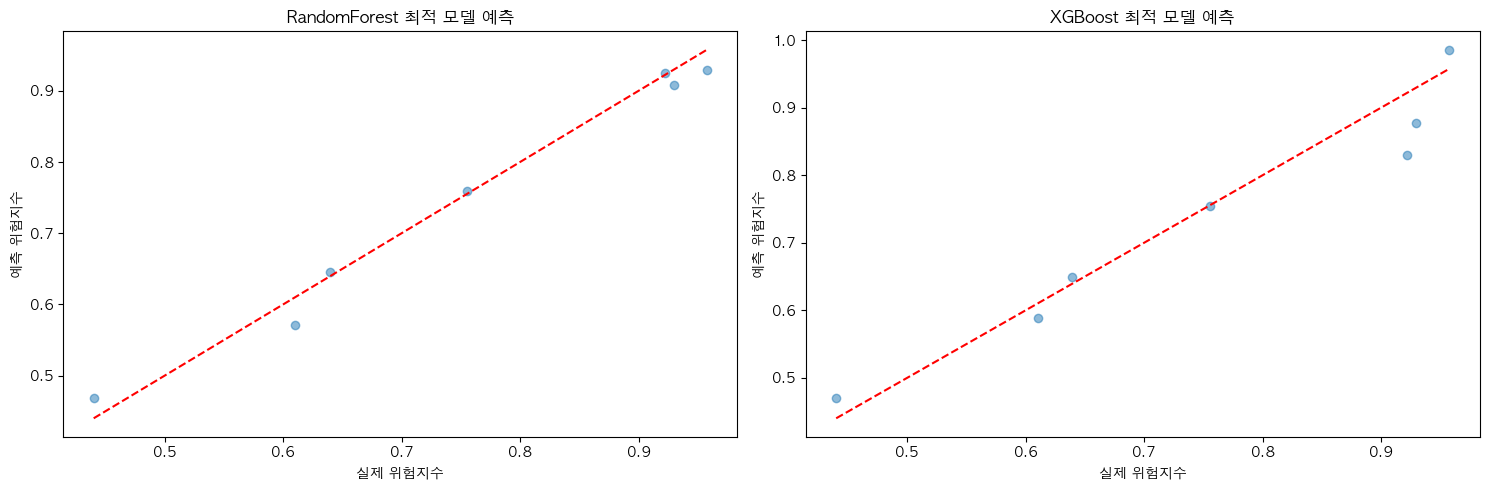

In [ ]:
# 적화된 모델들의 성능 비교
# RandomForest 최적 모델
rf_opt = RandomForestRegressor(**study.best_params, random_state=42)
rf_opt.fit(X_train_scaled, y_train)
y_pred_rf_opt = rf_opt.predict(X_test_scaled)

# XGBoost 최적 모델
xgb_opt = xgb.XGBRegressor(**study_xgb.best_params, random_state=42)
xgb_opt.fit(X_train_scaled, y_train)
y_pred_xgb_opt = xgb_opt.predict(X_test_scaled)

# 성능 비교
print("RandomForest 최적 모델 성능:")
print(f"R2 Score: {r2_score(y_test, y_pred_rf_opt):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf_opt):.4f}")

print("\nXGBoost 최적 모델 성능:")
print(f"R2 Score: {r2_score(y_test, y_pred_xgb_opt):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_xgb_opt):.4f}")

# 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf_opt, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('실제 위험지수')
plt.ylabel('예측 위험지수')
plt.title('RandomForest 최적 모델 예측')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_xgb_opt, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('실제 위험지수')
plt.ylabel('예측 위험지수')
plt.title('XGBoost 최적 모델 예측')

plt.tight_layout()
plt.show()

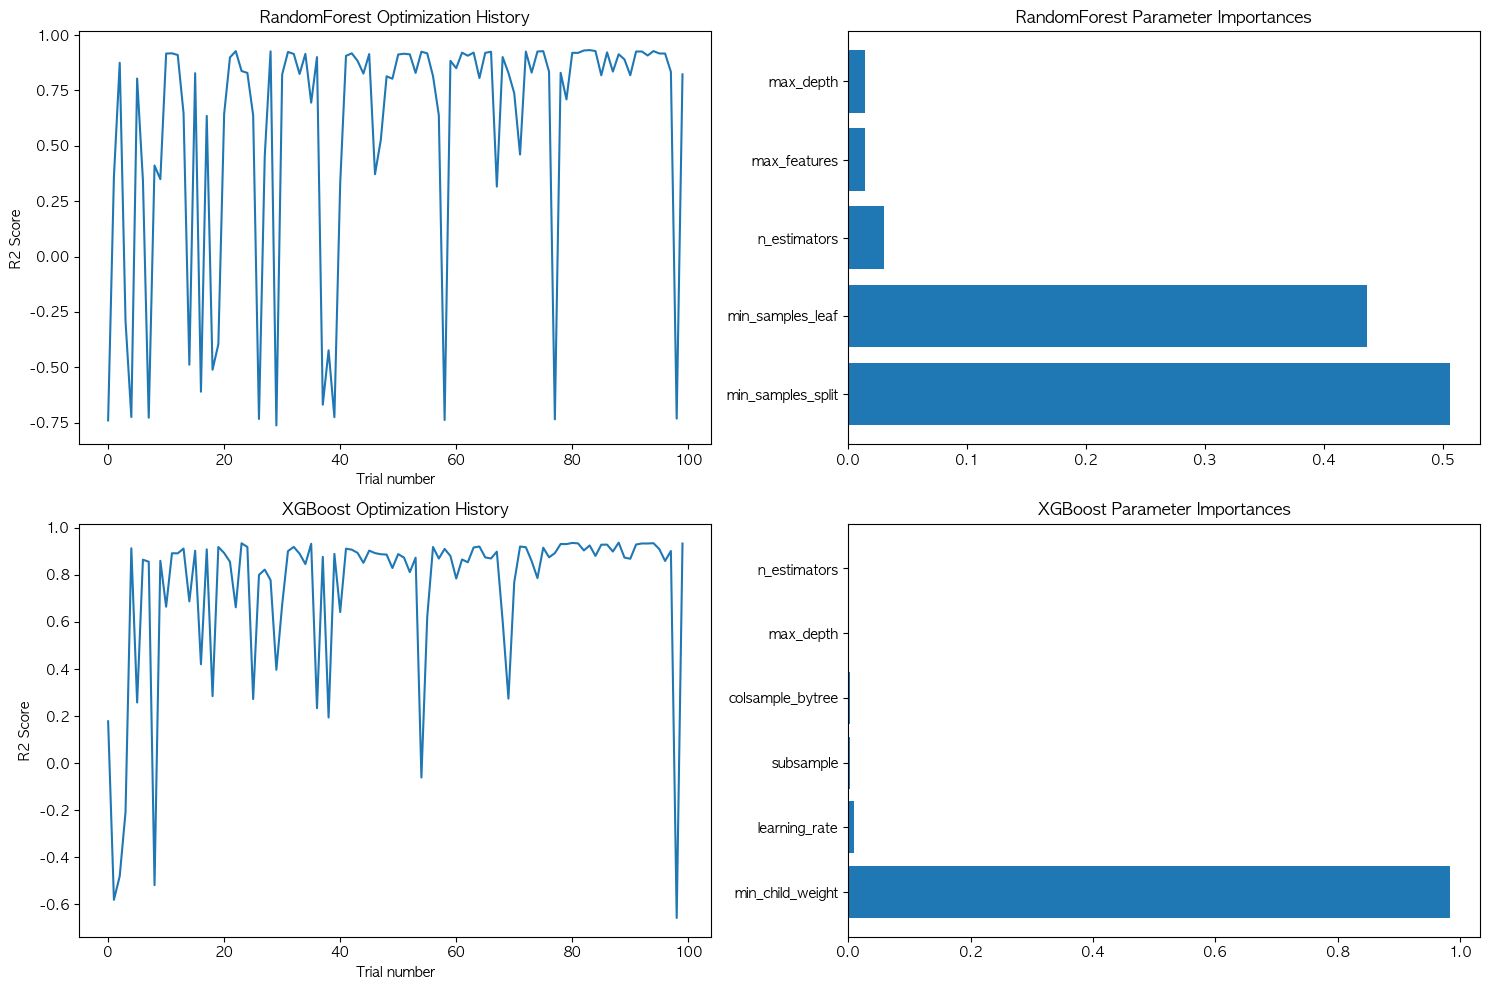

In [ ]:
# Optuna 시각화 (matplotlib 사용)
plt.figure(figsize=(15, 10))

# 최적화 히스토리
plt.subplot(2, 2, 1)
history = study.trials_dataframe()
plt.plot(history['number'], history['value'])
plt.xlabel('Trial number')
plt.ylabel('R2 Score')
plt.title('RandomForest Optimization History')

# 파라미터 중요도
plt.subplot(2, 2, 2)
importances = optuna.importance.get_param_importances(study)
params = list(importances.keys())
values = list(importances.values())
plt.barh(params, values)
plt.title('RandomForest Parameter Importances')

# XGBoost 최적화 히스토리
plt.subplot(2, 2, 3)
history_xgb = study_xgb.trials_dataframe()
plt.plot(history_xgb['number'], history_xgb['value'])
plt.xlabel('Trial number')
plt.ylabel('R2 Score')
plt.title('XGBoost Optimization History')

# XGBoost 파라미터 중요도
plt.subplot(2, 2, 4)
importances_xgb = optuna.importance.get_param_importances(study_xgb)
params_xgb = list(importances_xgb.keys())
values_xgb = list(importances_xgb.values())
plt.barh(params_xgb, values_xgb)
plt.title('XGBoost Parameter Importances')

plt.tight_layout()
plt.show()

In [23]:
# 최종 모델 선택 및 예측
if r2_score(y_test, y_pred_rf_opt) > r2_score(y_test, y_pred_xgb_opt):
    final_model = rf_opt
    print("선택된 최종 모델: RandomForest")
else:
    final_model = xgb_opt
    print("선택된 최종 모델: XGBoost")

# 전체 데이터셋에 대한 예측
model_data['예측위험지수'] = final_model.predict(scaler.transform(X))

# 예측 결과 분석
print("\n최종 모델 예측 결과 분석:")
print(f"평균 예측 오차: {np.mean(np.abs(model_data['위험지수'] - model_data['예측위험지수'])):.4f}")
print(f"예측 정확도 (R2 Score): {r2_score(model_data['위험지수'], model_data['예측위험지수']):.4f}")

# 상위 5개 고위험 예측 지역
print("\n상위 5개 예측 고위험 지역:")
predicted_high_risk = model_data.nlargest(5, '예측위험지수')
print(predicted_high_risk[['경찰서', '예측위험지수', '위험지수', 'CCTV밀도']])

선택된 최종 모델: RandomForest

최종 모델 예측 결과 분석:
평균 예측 오차: 0.0155
예측 정확도 (R2 Score): 0.9894

상위 5개 예측 고위험 지역:
       경찰서    예측위험지수      위험지수  CCTV밀도
26   서울송파서  0.965408  1.000000       0
10  서울영등포서  0.929823  0.957686       0
20   서울강서서  0.926162  0.935157       0
9    서울마포서  0.925111  0.922180       0
19   서울관악서  0.923784  0.929406       0
